In [260]:
pip install xmltodict

In [261]:
import cv2
import xmltodict
import numpy as np 
from copy import copy
from glob import glob
from random import randint
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.etree import cElementTree as ET

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [262]:
#!cd drive/MyDrive/

In [263]:
#!kaggle datasets download duythanhng/parking-lot-database-for-yolo

In [264]:
def dictify(r,root=True):
    if root:
        return {r.tag : dictify(r, False)}
    d=copy(r.attrib)
    if r.text:
        d["_text"]=r.text
    for x in r.findall("./*"):
        if x.tag not in d:
            d[x.tag]=[]
        d[x.tag].append(dictify(x,False))
    return d

In [271]:
imgs = []
for i in glob("drive/MyDrive/parking-lot-database-for-yolo/PKLotYoloData/HasXML/PUCPR/*/*/*.jpg"):
  if(i not in imgs):
    imgs.append(i)

In [465]:
def crop_image(img,pts):
  ## (1) Crop the bounding rect
  rect = cv2.boundingRect(pts)
  x,y,w,h = rect
  croped = img[y:y+h, x:x+w].copy()

  ## (2) make mask
  pts = pts - pts.min(axis=0)
  mask = np.zeros(croped.shape[:2], np.uint8)
  cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

  ## (3) do bit-op
  dst = cv2.bitwise_and(croped, croped, mask=mask)
  return dst

In [336]:
Y_train = []
X_train = []
for idx in range(len(imgs)):
  #idx = randint(0,len(imgs))
  #print(idx)
  #print(imgs[idx])
  img = cv2.imread(imgs[idx])
  #img = img[180:580,30:-120]
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  scale_percent = 80 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  #dim = (width, height)
  dim =(150,150)
  # resize image
  ##
  try:
    file = open(imgs[idx].replace("jpg","xml"),"r")
    root = ET.fromstring("\n".join(file.readlines()))
    dict_ = dictify(root)
    ##
    contours_o  = []
    contours_no = []
    contours_dk = []
    ##
    space = dict_["parking"]["space"]
    ##
    for i in range(len(space)):
        try:
          if(space[i]["occupied"] == "1"):
            point = [[int(i["x"]),int(i["y"])] for i in space[i]["contour"][0]["point"]]
            contours_o.append(point)
          else:
            point = [[int(i["x"]),int(i["y"])] for i in space[i]["contour"][0]["point"]]
            contours_no.append(point)
        except:
          point = [[int(i["x"]),int(i["y"])] for i in space[i]["contour"][0]["point"]]
          contours_dk.append(point)

    ##
    for cont in contours_no:
        
        pts = np.array(cont, np.int32)
        pts = pts.reshape((-1,1,2))
        #img = cv2.polylines(img,[pts],True,(0,255,0))
        dst = crop_image(img,pts)
        dst = cv2.resize(dst, (45,45), interpolation = cv2.INTER_AREA)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        X_train.append(dst)
        Y_train.append(0)
        
    for cont in contours_o:
        pts = np.array(cont, np.int32)
        pts = pts.reshape((-1,1,2))
        #img = cv2.polylines(img,[pts],True,(255,0,0))
        dst = crop_image(img,pts)
        dst = cv2.resize(dst, (45,45), interpolation = cv2.INTER_AREA)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        X_train.append(dst)
        Y_train.append(1)
      ##
  except:
    pass

In [343]:
import random
c = list(zip(X_train, Y_train))
random.shuffle(c)
X_train, Y_train = zip(*c)

In [344]:
X_train = np.asarray(X_train)

In [353]:
Y_train = np.asarray(Y_train)

In [369]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, Y_train, test_size=0.33, random_state=42)

Text(0.5, 1.0, 'Oc')

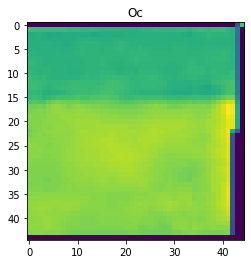

In [370]:
tidx = 198
plt.imshow(X_train[tidx])
plt.title("Oc" if Y_train[tidx] == 1 else "NOC")

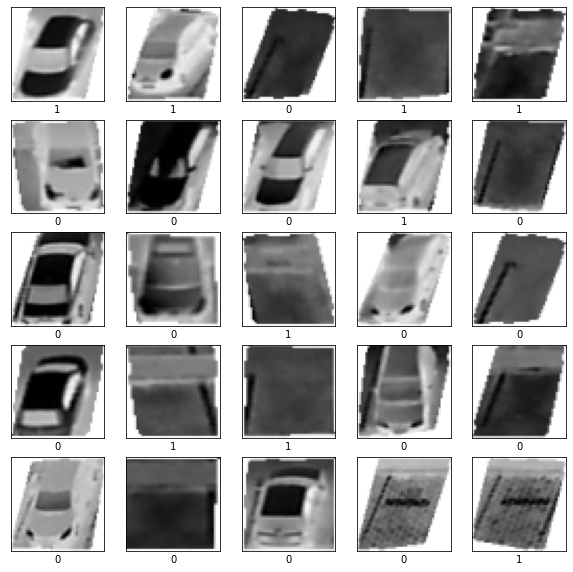

In [371]:
#let's plot some digit
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])
plt.show()

In [372]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [373]:
model =keras.Sequential([
    keras.Input(shape=(45, 45,1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1,activation = "sigmoid")
])

In [374]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 43, 43, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 flatten_22 (Flatten)        (None, 5184)              0         
                                                                 
 dropout_3 (Dropout)         (None, 5184)            

In [376]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,validation_split=0.33,epochs=10)

Epoch 1/10
2999/2999 [==============================] - 276s 92ms/step - loss: 0.0653 - accuracy: 0.9821 - val_loss: 0.0264 - val_accuracy: 0.9937
Epoch 2/10
2999/2999 [==============================] - 275s 92ms/step - loss: 0.0431 - accuracy: 0.9886 - val_loss: 0.0246 - val_accuracy: 0.9961
Epoch 3/10
2999/2999 [==============================] - 274s 91ms/step - loss: 0.0239 - accuracy: 0.9948 - val_loss: 0.0224 - val_accuracy: 0.9946
Epoch 4/10
2999/2999 [==============================] - 273s 91ms/step - loss: 0.0232 - accuracy: 0.9952 - val_loss: 0.0209 - val_accuracy: 0.9962
Epoch 5/10
2999/2999 [==============================] - 273s 91ms/step - loss: 0.0208 - accuracy: 0.9959 - val_loss: 0.0135 - val_accuracy: 0.9976
Epoch 6/10
2999/2999 [==============================] - 272s 91ms/step - loss: 0.0167 - accuracy: 0.9968 - val_loss: 0.0159 - val_accuracy: 0.9975
Epoch 7/10
2999/2999 [==============================] - 270s 90ms/step - loss: 0.0178 - accuracy: 0.9966 - val_loss: 0

In [377]:
##
from sklearn.metrics  import precision_score
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2205/2205 - 44s - loss: 0.0123 - accuracy: 0.9979 - 44s/epoch - 20ms/step

Test accuracy: 0.9979161024093628


In [455]:
model.save('model.h5')

In [416]:
prediction = model.predict(X_test)

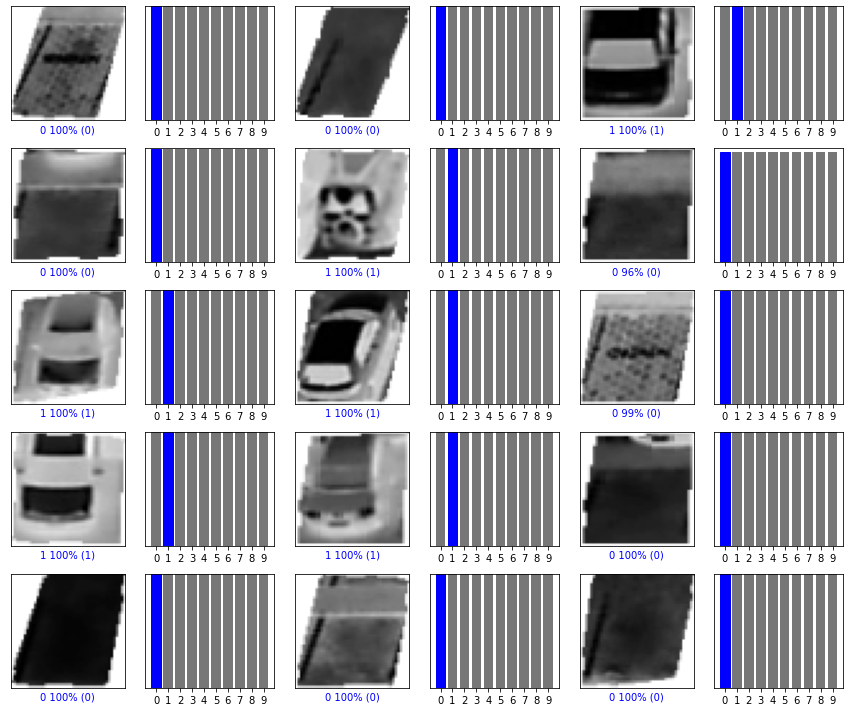

In [430]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, prediction[i], list(y_test), X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, prediction[i], list(y_test))
plt.tight_layout()
plt.show()

In [431]:
def plot_image(i, predictions_array, true_label, img):
    true_label = true_label[i]
    img        = img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = 0 if (predictions_array)< 0.5 else 1
    pourcent = predictions_array if predicted_label == 1 else 1-predictions_array
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(pourcent),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    predicted_label = 0 if (predictions_array)< 0.5 else 1
    pourcent = predictions_array if predicted_label == 1 else 1-predictions_array

    thisplot = plt.bar(range(10), pourcent, color="#777777")
    plt.ylim([0, 1])
    predicted_label = predicted_label

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [496]:
def deploy_model(image_path):
  oc = 0
  no_oc = 0
  cars_img = []
  img = cv2.imread(image_path)
  coordinate = pickle.load(open("drive/MyDrive/model/coordinates.pkl","rb"))
  for coor in coordinate:
      pts = np.array(coor, np.int32)
      pts = pts.reshape((-1,1,2))
      #img = cv2.polylines(img,[pts],True,(0,255,0))
      spot = crop_image(img,pts)
      spot = cv2.resize(spot, (45,45), interpolation = cv2.INTER_AREA)
      dst = cv2.cvtColor(spot, cv2.COLOR_BGR2GRAY)
      pred = model.predict(np.asarray([dst]))
      pred = 0 if pred < 0.5 else 1
      if(pred == 0):
        no_oc += 1
        img = cv2.polylines(img,[pts],True,(0,255,0))
      else:
        oc +=  1
        img = cv2.polylines(img,[pts],True,(255,0,0))
        cars_img.append(spot)
  
  return img,oc,no_oc,cars_img

In [497]:
idx = randint(0,len(imgs))
img,oc,no_oc,cars_img = deploy_model(imgs[idx])

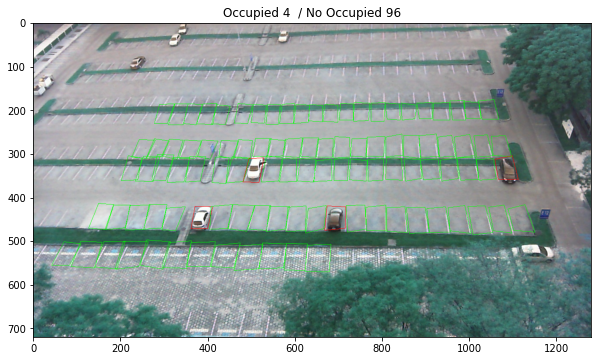

In [498]:
plt.figure(figsize=(10,10))
plt.title("Occupied {}  / No Occupied {}".format(oc,no_oc))
plt.imshow(img)

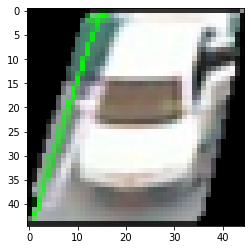

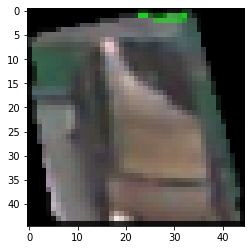

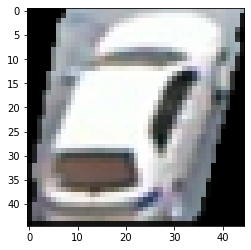

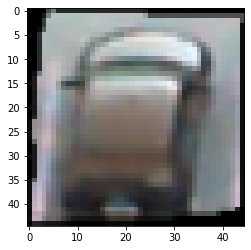

In [500]:
if(oc != 0):
  for i in cars_img:
    plt.imshow(i)
    plt.show()